In [15]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 


import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy.spatial import distance


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
PM25 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/PM25")

In [18]:
times = pd.date_range(start='2013-01-01 00:00:00', end='2018-12-31 23:00:00', freq='30Min') #one less because the last is always nan

In [19]:
start_year = PM25.shape[0]-times.shape[0]

In [20]:
# remove the last index as it is always nan
PM25 = PM25[:-1]
times = times[:-1]

In [21]:
threshold = 0.6 # how much non-missing values are in the time-series in order to include the station?

In [22]:
# reduced PM25 
r_PM25 = PM25[start_year:] 
idx = r_PM25.notnull().sum(axis = 0)/r_PM25.shape[0]>threshold
r_PM25 = r_PM25.loc[:, idx]

In [23]:
r_PM25.reset_index(inplace=True)
r_PM25.drop(labels = 'index',axis=1, inplace=True)

In [24]:
# r_PM25['datetime'] = pd.to_datetime(times)
r_PM25_withDays = r_PM25.copy()
r_PM25_withDays['week day'] = pd.to_datetime(times).dayofweek
r_PM25_withDays['month'] = pd.to_datetime(times).month
r_PM25_withDays['hour'] = pd.to_datetime(times).hour

In [25]:
# null percentages
r_PM25.shape[1]
1-r_PM25.notnull().sum(axis = 0)/r_PM25.shape[0]

34

AFULA              0.082660
ANTOKOLSKY         0.095611
HOLON              0.058488
IRONID             0.091893
KVISH4             0.238214
REMEZ              0.135196
YAD_LEBANIM        0.372896
YEFET_YAFO         0.183843
AHUZA_G            0.030295
ATZMAUT_B          0.107849
KIRYAT_ATA         0.275526
KIRYAT_BIALIK      0.308836
KIRYAT_BINYAMIN    0.033518
KIRYAT_TIVON       0.039347
NAVE_SHANAAN       0.041886
NESHER             0.152359
BAR_ILAN           0.229418
EFRATA             0.137630
ASHDOD_IGUD        0.078153
ASHKELON_SOUTH     0.252325
GEDERA             0.097465
GVARAAM            0.103921
KIRYAT_MALAHI      0.143573
NIR_ISRAEL         0.085788
ORT                0.233716
ROVA_TV            0.320161
SDEROT             0.072200
SDE_YOAV           0.039633
YAHALOM            0.258496
BEER_SHEVA         0.144552
EAST_NEGEV         0.273140
KFAR_MASARIK       0.233612
PARDES_HANA        0.263165
RAANANA            0.099024
dtype: float64

In [26]:
r_PM25.shape[0]
r_PM25.shape[1]
r_PM25.shape[1]*r_PM25.shape[0]

105166

34

3575644

# Functions

In [27]:
# keep the division of the CV identical to compare different algorithms. 
rnd_state_forCV = 0

In [14]:
# out of all non-nan indexes, perform 10-fold cross validation.
# the test is y_missing. copy r_PM25, put all null inside, and assign values from r_PM25 according to test indexes. 
# the train is X_missing. copy r_PM25, and assign nans according to test indexes. 
# the splitting currently doesn't try to preserve the original relative missing intervals
# of each feature. maybe I will add it somehow later. 

def KFold_cross_validation(imp,PM25,k,withDays):
    
    if withDays:
        wd = PM25['week day']
        m = PM25['month']
        h = PM25['hour']
        PM25.drop(['week day','month','hour'],axis=1,inplace=True)
        
        
    kf = KFold(n_splits=k, random_state=rnd_state_forCV, shuffle=True)
    not_nan_idx = np.argwhere(PM25.notnull().values)
    results = []
    
    for train_index, test_index in kf.split(not_nan_idx):
        np_PM25 = PM25.values
        X_missing = PM25.copy()
        y_missing = PM25.copy()
        
        # y_missing 
        y_missing.iloc[:] = np.nan
        np_y_missing = y_missing.values
        
        # asssign values according to test indexes
        rows, cols = zip(*not_nan_idx[test_index])
        vals = np_PM25[rows, cols]
        np_y_missing[rows, cols] = vals
        # turn back to dataframe
        y_missing = pd.DataFrame(np_y_missing,columns=PM25.columns)

        # X_missing
        # assign nans according to test indexes
        np_X_missing = X_missing.values
        np_X_missing[rows, cols] = np.nan
        
        # turn back to dataframe
        X_missing = pd.DataFrame(np_X_missing,columns=PM25.columns)
        
        if withDays:
            X_missing['week day']=wd
            X_missing['hour']=h
            X_missing['month']=m
        
        # perform fit 
        imp.fit(X_missing)
        imputed_df = imp.transform(X_missing) # impute it
        imputed_df = pd.DataFrame(imputed_df, columns=X_missing.columns) #turn it from IterativeImputer object to a dataframe
        
        if withDays:
            imputed_df.drop(['week day','hour','month'],axis = 1, inplace=True)
                       
        # evaluate
        y_train = vals
        np_imputed_df = imputed_df.values
        y_pred = np_imputed_df[rows, cols]
        
        # assign results
        RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
        MedianAE = median_absolute_error(y_train, y_pred)
        MeanAE = mean_absolute_error(y_train,y_pred)
        R2 = r2_score(y_train,y_pred)
        results.append([RMSE,MedianAE,MeanAE,R2])
               
    results = pd.DataFrame(results, columns=['RMSE','MedianAE','MeanAE','R2'])
    
    return results
        
        

# (1) IterativeImputer with BayesianRidge and ExtraTreesRegressor

In [15]:
# not sure about the random_state! plus I've read that no need for CV in random forest.
rnd_state_forRF = 0 # I believe I should play with this parameter as well. 
imp_RF = IterativeImputer(max_iter=10,estimator=ExtraTreesRegressor(n_estimators=30,random_state=rnd_state_forRF),verbose=True) 
imp_BR = IterativeImputer(max_iter=20,estimator=BayesianRidge(),verbose=True) 
# try also to change the initial imputer - mean/median/constant...
# and n_estimators (number of trees in the forest...)

## A - without days 

In [515]:
results_woD_RF = KFold_cross_validation(imp_RF,r_PM25,k=10,withDays=False)
results_woD_BR = KFold_cross_validation(imp_BR,r_PM25,k=10,withDays=False)

In [434]:
results_woD_RF
results_woD_RF.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_RF")

,RMSE,MedianAE,MeanAE,R2
0,9.276128,4.08,5.739155,0.840807
1,9.432850,4.06,5.744132,0.836131
2,9.288789,4.07,5.748222,0.844457
3,9.384672,4.07,5.732657,0.841935
4,9.580541,4.06,5.754636,0.836096
5,8.978527,4.06,5.708310,0.843317
6,9.436479,4.08,5.752286,0.822759
7,9.458052,4.06,5.748231,0.843511
8,9.773849,4.07,5.746742,0.830450
9,9.289947,4.06,5.728445,0.839699


In [435]:
results_woD_BR
results_woD_BR.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_BR")

,RMSE,MedianAE,MeanAE,R2
0,12.146577,4.757204,6.994312,0.727041
1,12.194144,4.789904,7.030386,0.726149
2,12.152302,4.783614,6.997097,0.733775
3,11.985335,4.777705,6.971577,0.742191
4,12.287126,4.785513,6.987615,0.730406
5,11.964026,4.740049,6.946813,0.721794
6,11.894747,4.788714,6.950691,0.718386
7,12.287924,4.753388,6.965011,0.735859
8,12.436219,4.793671,7.043854,0.725499
9,11.814214,4.763854,6.968005,0.740749


## B - without days, with normal data

## C - with days

In [284]:
r_PM25_withDays = r_PM25.copy()
r_PM25_withDays['week day'] = pd.to_datetime(times).dayofweek
r_PM25_withDays['month'] = pd.to_datetime(times).month
r_PM25_withDays['hour'] = pd.to_datetime(times).hour

In [ ]:
results_wD_RF = KFold_cross_validation(imp_RF,r_PM25_withDays,k=10,withDays=True)

In [296]:
r_PM25_withDays = r_PM25.copy()
r_PM25_withDays['week day'] = pd.to_datetime(times).dayofweek
r_PM25_withDays['month'] = pd.to_datetime(times).month
r_PM25_withDays['hour'] = pd.to_datetime(times).hour

In [297]:
results_wD_BR = KFold_cross_validation(imp_BR,r_PM25_withDays,k=10,withDays=True)

[IterativeImputer] Completing matrix with shape (105166, 37)
[IterativeImputer] Change: 6370.989565900771, scaled tolerance: 1.6975 
[IterativeImputer] Change: 969.4149125965786, scaled tolerance: 1.6975 
[IterativeImputer] Change: 576.5752099832307, scaled tolerance: 1.6975 
[IterativeImputer] Change: 314.0645142393083, scaled tolerance: 1.6975 
[IterativeImputer] Change: 322.1620220333494, scaled tolerance: 1.6975 
[IterativeImputer] Change: 591.9714768692887, scaled tolerance: 1.6975 
[IterativeImputer] Change: 402.6942882366628, scaled tolerance: 1.6975 
[IterativeImputer] Change: 227.65040323712557, scaled tolerance: 1.6975 
[IterativeImputer] Change: 255.33190960520187, scaled tolerance: 1.6975 
[IterativeImputer] Change: 68.29994123160066, scaled tolerance: 1.6975 
[IterativeImputer] Change: 24.690867515296304, scaled tolerance: 1.6975 
[IterativeImputer] Change: 31.06321102042409, scaled tolerance: 1.6975 
[IterativeImputer] Change: 26.95427791276279, scaled tolerance: 1.6975 


KeyboardInterrupt: 

In [289]:
results_wD_RF
results_wD_RF.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_wD_RF")

,RMSE,MedianAE,MeanAE,R2
0,8.891562,3.92,5.534868,0.853733
1,9.149023,3.91,5.548026,0.845844
2,9.096198,3.92,5.541519,0.850840
3,9.082441,3.92,5.530160,0.851952
4,9.146131,3.92,5.526155,0.850623
5,8.726580,3.90,5.507559,0.851987
6,9.026643,3.92,5.541228,0.837821
7,8.909576,3.92,5.532779,0.861135
8,9.330047,3.92,5.543148,0.845498
9,8.908671,3.91,5.527290,0.852587


In [290]:
results_wD_BR
results_wD_BR.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_wD_BR")

,RMSE,MedianAE,MeanAE,R2
0,12.158469,4.748910,6.987025,0.726506
1,12.090359,4.771156,6.990287,0.730790
2,12.276467,4.774440,7.002976,0.728307
3,12.019256,4.780598,6.978572,0.740730
4,12.290798,4.755746,6.963742,0.730245
5,11.957039,4.712760,6.909068,0.722118
6,11.910672,4.785016,6.948598,0.717632
7,12.271235,4.737253,6.951292,0.736576
8,12.365174,4.775569,7.010698,0.728627
9,11.850018,4.763862,6.965597,0.739175


## D - with days, with normal data

In [ ]:
# wind/other met./other pollutants

# (2) KNN

## A - iterative imputer - VERY SLOW!

In [20]:
# take 10 neighbors.  
imp_KNN = IterativeImputer(max_iter=1,estimator=KNeighborsRegressor(n_neighbors=10,weights='distance',n_jobs=-1),verbose=True) 

In [21]:
results_woD_KNN = KFold_cross_validation(imp_KNN,r_PM25,k=10,withDays=False)

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 6535.141122235329, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 6002.413284248385, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 5271.845720152767, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 5553.4065955871465, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 5037.528838168532, scaled tolerance: 1.5118 
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Completing

In [22]:
results_woD_KNN
results_woD_KNN.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_KNN")

,RMSE,MedianAE,MeanAE,R2
0,9.510036,3.917365,5.554462,0.832678
1,9.613944,3.911642,5.548207,0.829778
2,9.765258,3.925400,5.568478,0.828091
3,9.753575,3.911715,5.546650,0.829264
4,10.007616,3.922956,5.578250,0.821158
5,9.248886,3.893837,5.512880,0.833739
6,9.498568,3.923674,5.549481,0.820419
7,9.944436,3.911382,5.557848,0.827003
8,9.962109,3.908708,5.549101,0.823855
9,9.462517,3.916427,5.547056,0.833688


## B - my KNN implemintation (on rows! not columns!)

In [128]:
def return_X_y_KFold_cross_validation(PM25,k):
   
    kf = KFold(n_splits=k, random_state=rnd_state_forCV, shuffle=True)
    not_nan_idx = np.argwhere(PM25.notnull().values)
    results = []
    
    for train_index, test_index in kf.split(not_nan_idx):
        np_PM25 = PM25.values
        X_missing = PM25.copy()
        y_missing = PM25.copy()
        
        # y_missing 
        y_missing.iloc[:] = np.nan
        np_y_missing = y_missing.values
        
        # asssign values according to test indexes
        rows, cols = zip(*not_nan_idx[test_index])
        vals = np_PM25[rows, cols]
        np_y_missing[rows, cols] = vals
        # turn back to dataframe
        y_missing = pd.DataFrame(np_y_missing,columns=PM25.columns)

        # X_missing
        # assign nans according to test indexes
        np_X_missing = X_missing.values
        np_X_missing[rows, cols] = np.nan
        
    return np_X_missing, np_y_missing

In [129]:
r_PM25_copy = r_PM25.copy()
# np_r_PM25 = r_PM25_copy.values
# np_r_PM25.shape


np_r_PM25, np_r_PM25_y = return_X_y_KFold_cross_validation(r_PM25_copy,10)

In [130]:
np_r_PM25.shape

(105166, 34)

In [131]:
# start with filling rows where ALL columns are nan, with the 
# mean values suited for the days of week, hour and month. 
# if starting in 2013, I have 5 rows like that (all 34 stations are missing).
# later, the largest missing row is 24 (so 10 stations exist). 
# but, should keep track if changing year !!

order = np.sort(np.isnan(np_r_PM25).sum(axis=1))
num_idx = np.sum(order==34)
# num_idx

order = np.argsort(np.isnan(np_r_PM25).sum(axis=1))
# np_r_PM25[order[-num_idx:],:]
idx = order[-num_idx:]

In [132]:
times_dt = pd.to_datetime(times)
r_PM25_copy['datetime'] = pd.to_datetime(times)
means_to_impute_by = r_PM25_copy.groupby([r_PM25_copy.datetime.dt.month, r_PM25_copy.datetime.dt.dayofweek, r_PM25_copy.datetime.dt.hour]).mean()

In [133]:
for i in range(len(idx)):
    np_r_PM25[idx[i],:] = means_to_impute_by.loc[(times_dt[i].month,times_dt[i].dayofweek,times_dt[i].hour),:].values

In [458]:
# distances
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

In [459]:
# the nan values are very problematic, as the shortest distance would be from other 
# times with lots of nans!!!

# I should consider the distance only for non-nan values and divide by the size of the 
# compared vactors so I give better score (=shorter distance) to larger vectors. 
# maybe first keep another column with the size of the common elements. 

In [24]:
# r_PM25

In [134]:

corrMatrix = pd.DataFrame(np_r_PM25).corr()
np_corrMatrix = corrMatrix.values
np_corrMatrix

array([[1.        , 0.71062729, 0.67445461, ..., 0.68373208, 0.74438546,
        0.6862371 ],
       [0.71062729, 1.        , 0.84616509, ..., 0.67813413, 0.75209815,
        0.80789156],
       [0.67445461, 0.84616509, 1.        , ..., 0.58814967, 0.69079053,
        0.78469723],
       ...,
       [0.68373208, 0.67813413, 0.58814967, ..., 1.        , 0.62888071,
        0.66144483],
       [0.74438546, 0.75209815, 0.69079053, ..., 0.62888071, 1.        ,
        0.75306561],
       [0.6862371 , 0.80789156, 0.78469723, ..., 0.66144483, 0.75306561,
        1.        ]])

In [135]:

def get_distance(all_data, idx, j, num_neighbors, all_data_mask_nans, all_data_mask_total, np_corrMatrix):           
    dist = distance.cdist(all_data_mask_nans, ((1/np_corrMatrix[:,j])*(all_data_mask_nans[idx,:].reshape(-1, 1))).T, metric='euclidean') 
#     dist = distance.cdist(all_data_mask_nans, all_data_mask_nans[idx,:].reshape(-1, 1).T, metric='cosine') #cosine 

    # I think if its cosine the corr is just multiplied and if euclidean the corr^2. not sure. 
#     dist = distance.cdist(all_data_mask_nans, all_data_mask_nans[idx,:].reshape(-1, 1).T, lambda u, v: np.sqrt(np.nansum((u-v)**2)))
#     dist = distance.cdist(all_data_mask_nans, all_data_mask_nans[idx,:].reshape(-1, 1).T, lambda u, v: 1-np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v)))
    
    length = np.dot(all_data_mask_total, all_data_mask_total[idx,:].reshape(-1, 1))
    
    return np.delete(dist/length, idx) #return everything but distance with itself

# zero = they are very similar(zero angle, cos=1, 1-cos=0). one = they are different. 

def get_neighbors(all_data, idx, j, num_neighbors, all_data_mask_nans, all_data_mask_total, np_corrMatrix):
    dist = get_distance(all_data, idx, j, num_neighbors, all_data_mask_nans, all_data_mask_total, np_corrMatrix)
    return np.array(dist), np.delete(all_data, idx, axis=0) # don't return the imputed row itself

In [82]:
# len(np.delete(imputed,1,axis=0))

In [83]:
# sort np_r_PM25, so I call the get_all_neighbors function by asc order 
# of number of nans in a row. 
order = np.argsort(np.isnan(np_r_PM25).sum(axis=1))

In [136]:
imputed = np_r_PM25.copy()
imputed = imputed[order,:] # imputed is sorted by number of nan values in a row (asc)
num_neighbors = imputed.shape[0]

In [137]:
all_data_mask_nans = imputed.copy()
all_data_mask_total = imputed.copy()

mask_nans = np.isnan(imputed)

all_data_mask_nans[mask_nans]=0
all_data_mask_total[mask_nans]=0
all_data_mask_total[~mask_nans]=1

In [ ]:
returned_imputed = imputed.copy()

In [114]:
# BUG - the imputed matrix should not be changed during run. (dont use it to feed the data)
# Don't order?
# Don't take all neighbors?

for i in tqdm(range(len(imputed))): # perform impute per row, to save time. 
    nan_ind = np.argwhere(mask_nans[i,:])
    if nan_ind.any():
        for j in nan_ind:
                      
            weights, neighbors = get_neighbors(imputed, i, j, num_neighbors, all_data_mask_nans, all_data_mask_total, np_corrMatrix)    
            
            fill_by = np.squeeze(neighbors[:,j])
            # turn nan to zeros so it won't be accounted for 
            
            weights[np.isnan(fill_by)] = 0
            fill_by[np.isnan(fill_by)] = 0
            
            # weights is normalized after removing the nan values. 
            weights = 1/weights
            weights = weights/np.sum(weights)

            returned_imputed[i,j] = np.dot(fill_by.reshape(-1, 1).T,weights)

In [95]:
# DON'T FORGET TO TURN IT BACK TO THE ORDER!!
order
# maybe add order as index to imputed and then sort. 

array([ nan, 28.1, 55. , 43.8,  nan,  nan,  nan,  nan, 17.8, 31.2, 14.9,
        3.4,  9.7, 22.3, 16. , 18.3, 24. ,  nan, 29. ,  nan, 40.5, 61.7,
       35.4, 57.6, 39.2, 39.2, 45.7, 35.1, 52.4, 35.3,  nan,  9.3, 16.9,
        nan])

In [364]:
from sklearn.metrics import pairwise_distances 

In [ ]:
# Coockies:

In [373]:
from sklearn.metrics.pairwise import nan_euclidean_distances

In [451]:
# fix - either reduce the minimum weight and **2 to enhace the diff between weights.
# or - take top X neighbors... 
imputed = np_r_PM25.copy()   
all_data_mask_nans = imputed.copy()
mask_nans = np.isnan(imputed)
all_data_mask_nans[mask_nans]=0

batch_size = 300
not_nan_mask = 1-np.isnan(np_r_PM25).astype(int)
# all_data_norm = all_data_mask_nans / np.linalg.norm(all_data_mask_nans,axis=1)[:,np.newaxis] # normalize BY norm
all_data_norm = np_r_PM25 / np.nanstd(np_r_PM25, axis=0) # normalize BY norm 

In [452]:
all_data_norm

array([[       nan, 1.21775146, 2.63760368, ..., 0.51512838, 0.87558288,
               nan],
       [       nan,        nan, 2.63760368, ...,        nan, 0.87558288,
               nan],
       [       nan, 1.20041692, 2.63760368, ..., 1.11888099, 0.61653469,
               nan],
       ...,
       [1.16686034, 1.235086  , 1.04545018, ..., 1.07456887, 1.94804238,
        0.95539615],
       [1.00713801, 1.26975508, 1.15574997, ..., 1.48445597, 1.70971805,
               nan],
       [0.59008526, 1.17874874, 2.15803937, ...,        nan, 1.7304419 ,
        2.55799613]])

In [586]:
corrMatrix = pd.DataFrame(np_r_PM25).corr()
np_corrMatrix = corrMatrix.values
np_corrMatrix = np_corrMatrix

In [594]:
np_corrMatrix[:,1]

array([0.14024738, 0.42962009, 0.27578519, 0.30342475, 0.2992061 ,
       0.30142183, 0.34367741, 0.16056611, 0.13143179, 0.11150276,
       0.14073225, 0.15594543, 0.02387634, 0.10159679, 0.14430182,
       0.14989349, 0.0082601 , 0.08547417, 0.25439589, 0.16605012,
       0.27472519, 0.21484706, 0.16131178, 0.26453146, 0.25563803,
       0.23786055, 0.1780315 , 0.16120278, 0.2528315 , 0.15381785,
       0.        , 0.10775423, 0.18171824, 0.23751165])

In [ ]:
for cind in tqdm(range(np_r_PM25.shape[1])):
    nan_column_mask = np.isnan(np_r_PM25[:,cind])
    not_nan_column_mask = np.logical_not(nan_column_mask)
    
    # lets remove correlations from here:
#     not_nan_data_corr = all_data_mask_nans[not_nan_column_mask, :] * np_corrMatrix[:, cind]
    
    not_nan_in_colom_all_data_norm = all_data_norm[not_nan_column_mask, :]*np_corrMatrix[:,cind]
    
#     var_not_nan_data_corr = not_nan_data_corr.var(axis=0)
    
#     not_nan_not_nan_mask = not_nan_mask[not_nan_column_mask, :] #relevant rows for this column (not nan)
    
    not_nan_column = np_r_PM25[not_nan_column_mask,cind]
    
    nan_ind = np.argwhere(nan_column_mask)
    for i in tqdm(range(0, len(nan_ind), batch_size), leave=False):
        rinds = np.squeeze(nan_ind[i:i+batch_size])
        batch = all_data_norm[rinds, :]*np_corrMatrix[:,cind]
#         batch_non_nan_mask = not_nan_mask[rinds, :]
#         counts = np.dot(not_nan_not_nan_mask, batch_non_nan_mask.T)
#         dists = distance.cdist(not_nan_data_corr, batch, 'seuclidean', V=var_not_nan_data_corr)
        
        dists = nan_euclidean_distances(not_nan_in_colom_all_data_norm, batch)
        
        weights = 1/dists
        min_thr = np.partition(weights,-11,axis=0)[-11,:]
        weights = weights-min_thr
        weights[weights<0] = 0
        weights = weights / weights.sum(axis=0)
        
        values = np.dot(weights.T, not_nan_column)
        imputed[rinds, cind] = values
    

HBox(children=(IntProgress(value=0, max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

HBox(children=(IntProgress(value=0, max=66), HTML(value='')))

In [595]:
not_nan_in_colom_all_data_norm*np_corrMatrix[:,cind]

array([[0.74803261, 0.06367209, 0.03853928, ..., 0.03161049,        nan,
        0.04461469],
       [0.64191809, 0.06754447, 0.04061128, ..., 0.03170866, 0.11619022,
        0.04778089],
       [0.81005729, 0.05973623, 0.03722701, ..., 0.03774607, 0.13704488,
        0.04955589],
       ...,
       [0.19653604, 0.01809227, 0.00752828, ..., 0.00952242, 0.0466747 ,
        0.00892294],
       [0.16963377, 0.01860012, 0.00832255, ..., 0.01315468, 0.0409645 ,
               nan],
       [0.09938895, 0.01726701, 0.01554003, ...,        nan, 0.04146104,
        0.02389045]])

In [596]:
not_nan_in_colom_all_data_norm[weights[:,1]!=0][0]

array([0.14930991, 0.08811697, 0.07528611, 0.07320005,        nan,
       0.03858599,        nan, 0.04994302, 0.11078453, 0.15143613,
       0.09033975,        nan, 0.11304242, 0.22252519, 0.12492289,
              nan,        nan,        nan, 0.04834989, 0.        ,
       0.0376175 , 0.04923183, 0.02231925, 0.03773801, 0.03242966,
              nan, 0.03808839, 0.00691716, 0.04394712, 0.026936  ,
       0.04393874,        nan,        nan, 0.05658973])

In [597]:
imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe

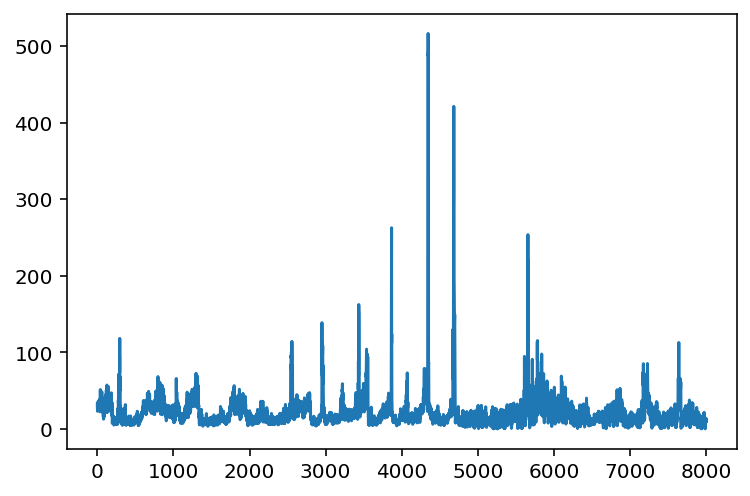

In [598]:
imputed_df.loc[:8000,'AFULA'].plot()

In [599]:
# pairwise_distances([[1, np.nan, 2, np.nan]], [[2, 3, np.nan, np.nan]],'nan_euclidean') 

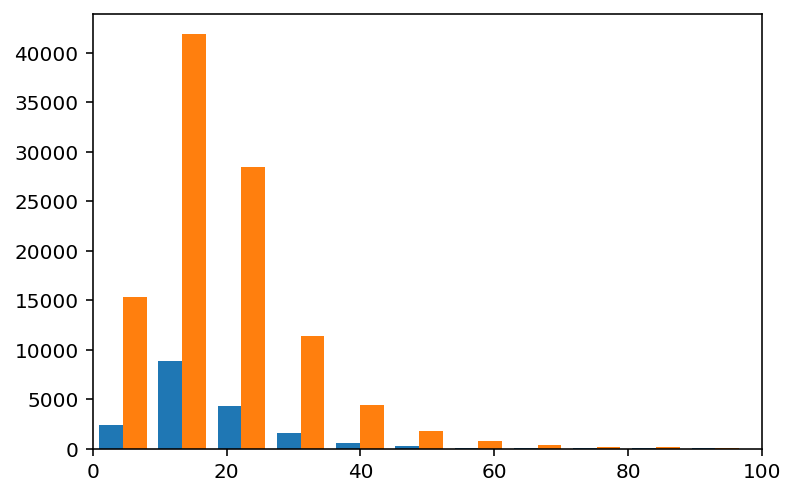

In [600]:
plt.hist([imputed[mask_nans], imputed_df['AFULA']],bins=100)

plt.xlim([0,100])
plt.show();

In [601]:
imputed[mask_nans]

array([28.44371716,         nan,         nan, ...,         nan,
               nan,         nan])

In [602]:
# corrMatrix.sort_values()

In [603]:
imputed_df.head()

,AFULA,ANTOKOLSKY,HOLON,IRONID,KVISH4,REMEZ,YAD_LEBANIM,YEFET_YAFO,AHUZA_G,ATZMAUT_B,...,ORT,ROVA_TV,SDEROT,SDE_YOAV,YAHALOM,BEER_SHEVA,EAST_NEGEV,KFAR_MASARIK,PARDES_HANA,RAANANA
0,28.443717,28.1,55.0,43.8,NaN,NaN,NaN,NaN,17.8,31.2,...,39.2,39.2,45.7,35.1,52.4,35.3,NaN,9.3,16.9,NaN
1,34.532560,NaN,55.0,NaN,NaN,NaN,18.5,NaN,17.8,38.8,...,49.0,49.0,54.0,34.4,42.4,33.1,NaN,NaN,16.9,NaN
2,31.330445,27.7,55.0,NaN,NaN,NaN,21.7,NaN,16.2,43.3,...,43.8,43.8,48.0,44.9,NaN,25.9,NaN,20.2,11.9,NaN
3,23.063193,26.3,64.6,48.7,NaN,NaN,23.6,NaN,17.1,39.3,...,39.4,39.4,25.6,34.6,45.4,26.4,NaN,16.6,15.1,NaN
4,27.699801,28.0,71.0,44.7,NaN,NaN,25.0,NaN,18.3,37.1,...,42.5,42.5,20.3,26.0,35.1,34.6,NaN,14.4,17.0,NaN


In [604]:
np_imputed_df = imputed_df.values

In [605]:
y_train = np_r_PM25_y[~np.isnan(np_r_PM25_y[:,0]),0]
y_pred = np_imputed_df[~np.isnan(np_r_PM25_y[:,0]),0]

In [606]:
y_train

array([19.4, 16.2, 20.7, ...,  5.1, 10.6, 18.9])

In [607]:
y_pred

array([11.5866163 , 13.71118183, 14.33979798, ...,  7.62142247,
       22.51479153, 28.26463028])

In [608]:
# y_train = y_train[~np.isnan(y_pred)]
# y_pred = y_pred[~np.isnan(y_pred)]

In [609]:

# assign results
RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)

[RMSE,MedianAE,MeanAE,R2]



[9.746133363247665, 4.2881247763626185, 5.777869741781203, 0.8003096266041133]

# (3) ARIMA/LSTM/Prophet/the simplest ever for 1-? missing time-steps (short intervals)

In [ ]:
# ARIMA might be problematic since I need to tune the parameters all the time. Does LSTM 
# require less parameters? in addition, I could predic short intervals but then continue 
# to predict with the LSTM with the long intervals as -1, as described in machinelearning
# mastery. 

# (4) Run models 1-2 again with the short-interval imputed values

In [ ]:
# others
# https://impyute.readthedocs.io/en/latest/index.html
# https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
# statsmodels MICE
# datawig 


# (5) Statistical imputation, just for comparison?

# (6) visualize results (box-plots + interactive time series+distribution of imputed values)

In [ ]:
# trash

s = pd.Series(tuple(map(tuple, not_nan_idx[test_index])))
vals = s.apply(lambda xy: r_PM25.iloc[xy[0],xy[1]])

In [178]:
PM25=r_PM25
k=2
withDays=False

kf = KFold(n_splits=k, random_state=0, shuffle=True)
not_nan_idx = np.argwhere(PM25.notnull().values)
results = []

In [179]:
for train_index, test_index in kf.split(not_nan_idx):
        train_index
        test_index

array([      1,       3,       4, ..., 1754019, 1754021, 1754024])

array([      0,       2,       6, ..., 1754023, 1754025, 1754026])

array([      0,       2,       6, ..., 1754023, 1754025, 1754026])

array([      1,       3,       4, ..., 1754019, 1754021, 1754024])

In [139]:
np_PM25 = PM25.values
X_missing = PM25.copy()
y_missing = PM25.copy()

# y_missing 
y_missing.iloc[:] = np.nan
np_y_missing = y_missing.values

# asssign values according to test indexes
rows, cols = zip(*not_nan_idx[test_index])
vals = np_PM25[rows, cols]
np_y_missing[rows, cols] = vals
# turn back to dataframe
y_missing = pd.DataFrame(np_y_missing,columns=PM25.columns)

# X_missing
# assign nans according to test indexes
np_X_missing = X_missing.values
np_X_missing[rows, cols] = np.nan

# turn back to dataframe
X_missing = pd.DataFrame(np_X_missing,columns=PM25.columns)

# mask all missing values
indicator = MissingIndicator(missing_values=np.nan)
mask_missing_values_original = indicator.fit_transform(PM25)
mask_missing_values_all = indicator.fit_transform(X_missing)

# perform fit 
imp.fit(X_missing)
imputed_df = imp.transform(X_missing) # impute it
imputed_df = pd.DataFrame(imputed_df, columns=X_missing.columns) #turn it from IterativeImputer object to a dataframe

[IterativeImputer] Completing matrix with shape (52606, 39)
[IterativeImputer] Change: 6112.810739330168, scaled tolerance: 1.133 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
                 max_iter=1, verbose=True)

[IterativeImputer] Completing matrix with shape (52606, 39)


In [180]:
# evaluate
# y_train = inverse_y_missing.values
y_train = vals

# y_pred = inverse_imputed_df.mask(~mask).values
np_imputed_df = imputed_df.values
y_pred = np_imputed_df[rows, cols]

In [181]:
y_train.shape
y_pred.shape

(877013,)

(877013,)

In [182]:
# assign results
RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)
# results.append([RMSE,MedianAE,MeanAE,R2])

In [183]:
# assign results
RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
MedianAE = median_absolute_error(y_train, y_pred)
MeanAE = mean_absolute_error(y_train,y_pred)
R2 = r2_score(y_train,y_pred)
results.append([RMSE,MedianAE,MeanAE,R2])

In [184]:
results

[[12.065151202546158,
  4.540000000000001,
  6.837151125467923,
  0.5649296791889007]]

In [ ]:
# # do I need to sort all rows so I start with imputing the row with the smallest number 
# # of missing values? I think so. 

# # for i,row in enumerate(np_r_PM25):  
# #     # euclidean
# #     distance.cdist(np_r_PM25, row.reshape(-1, 1).T, lambda u, v: np.sqrt(np.nansum((u-v)**2)))
# #     print(i)
# # each chunk I get, is an array of all distances of row i with all other rows.
# # this is why in the first chunk 0 is first, in the second chunk 0 is second...
# # Once distances are calculated, we must sort all of the records in the training 
# # dataset by their distance to the new data (the desired row). 
# # We can then select the top k to return as the most similar neighbors. 


# def get_distance(all_data, imputed_row):

#     # when I want to compute it to all elements in the row, including nans:
#     dist = distance.cdist(all_data, imputed_row.reshape(-1, 1).T, lambda u, v: np.sqrt(np.nansum((u-v)**2)))
#     return dist
    
# # Locate the most similar neighbors of a row. 
# # all_data = np_r_PM25
# # imputed_row = the current row you want to impute. 

# def get_neighbors(all_data, imputed_row, num_neighbors):
#     dist = get_distance(all_data, imputed_row)
#     distances = list(zip(np_r_PM25, dist))    
#     distances.sort(key=lambda tup: tup[1])
#     neighbors = list()
#     for i in range(num_neighbors):
#         neighbors.append(distances[i][0])
#     return neighbors


# # # get_all_neighbors weigh all the neighbors. 
# # # so no need to sort
# # def get_all_neighbors(all_data, imputed_row):
# #     dist,no_elements = get_distance(all_data, imputed_row)
    
# #     distances = list(zip(np_r_PM25, dist, no_elements))

# #     return neighbors
    
 



# #     distance.cdist(np.delete(np_r_PM25, i,axis=0), row.reshape(-1, 1).T, lambda u, v: np.dot(u, v)/(np.linalg.norm(u)*np.linalg.norm(v)))
# #     distance.cdist(np.delete(np_r_PM25, i,axis=0), row.reshape(-1, 1).T, 'cosine') #euclidean

# # dot(a, b)/(norm(a)*norm(b))

In [ ]:
# # from the begining!
# def get_distance(row1, row2):   
#     cond = np.array((np.isnan(row1)) | (np.isnan(row2)))    
#     # divide the dist by the number of elements compared
#     dist = distance.cosine(row1[~cond],row2[~cond])/np.sum(~cond) #euclidean/cosine...
#     return dist

# def get_neighbors(all_data, imputed_row, num_neighbors):
#     distances = list()
#     weights = list()
#     for row in all_data:
#         dist = get_distance(imputed_row, row)
#         distances.append((row, dist))
#     distances.sort(key=lambda tup: tup[1])
#     neighbors = list() 
#     for i in range(num_neighbors):
#         neighbors.append(distances[i][0])
#         weights.append(distances[i][1])
#     return weights[1:], neighbors[1:] # don't return the imputed row itself

In [ ]:
# fig, ax = plt.subplots(figsize=(20,12))
# corrMatrix = r_PM25.corr()
# corrMatrix
# sns.heatmap(corrMatrix, annot=True)
# plt.show();